Loading grid & computing microphysics snow fraction…
Loaded T2_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Loaded SNOWNC_2000-03.nc (cached)
Loaded HAILNC_2000-03.nc (cached)
Loaded GRAUPELNC_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Computing PPM for 'McCabe and Wolock (1999)'…
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Computing PPM for 'Dai (2008)'…
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)


/bsuhome/chiaraaltobelli/miniconda3/envs/snowpack-model/lib/python3.11/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


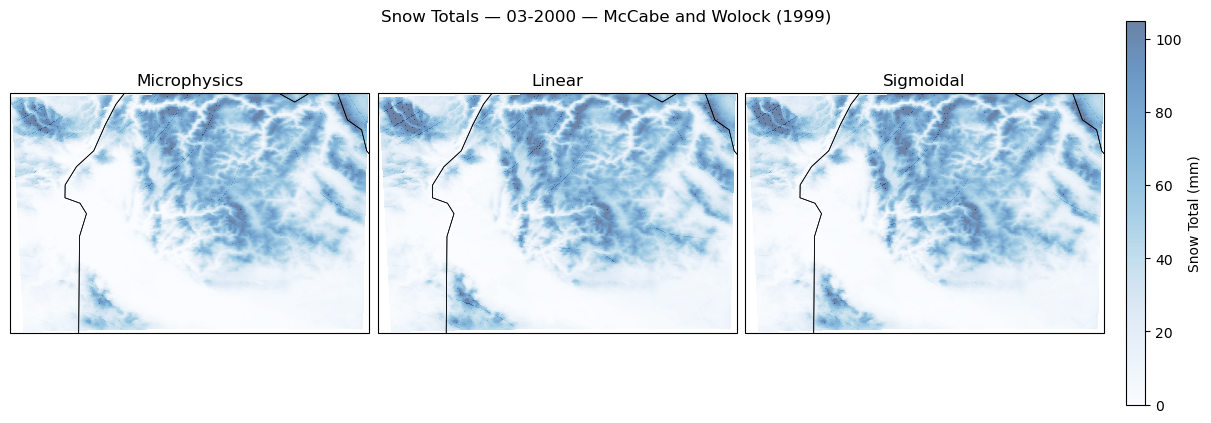

/bsuhome/chiaraaltobelli/miniconda3/envs/snowpack-model/lib/python3.11/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


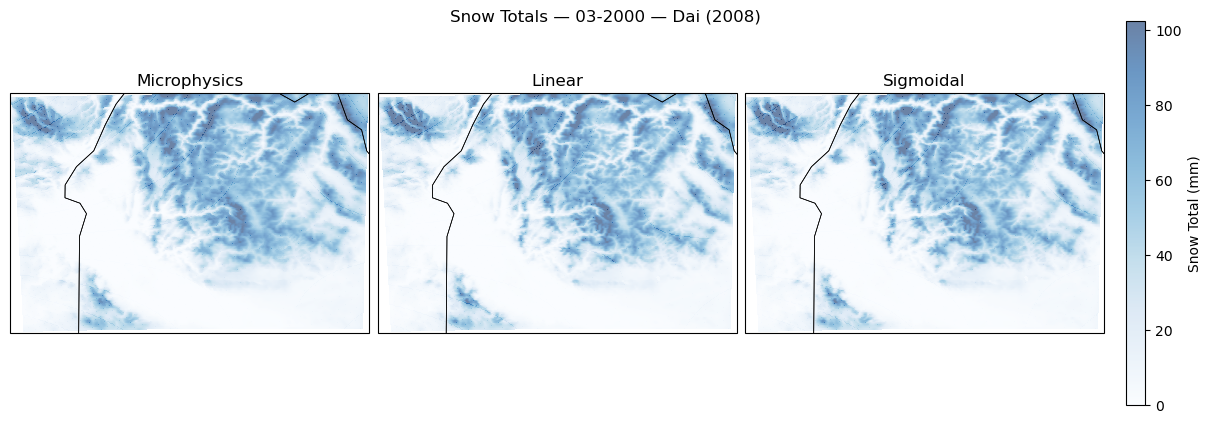

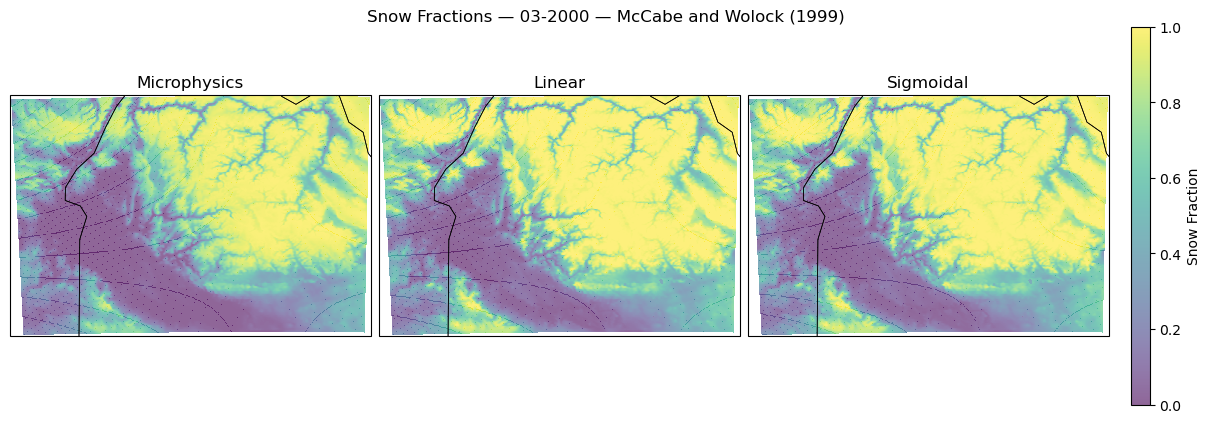

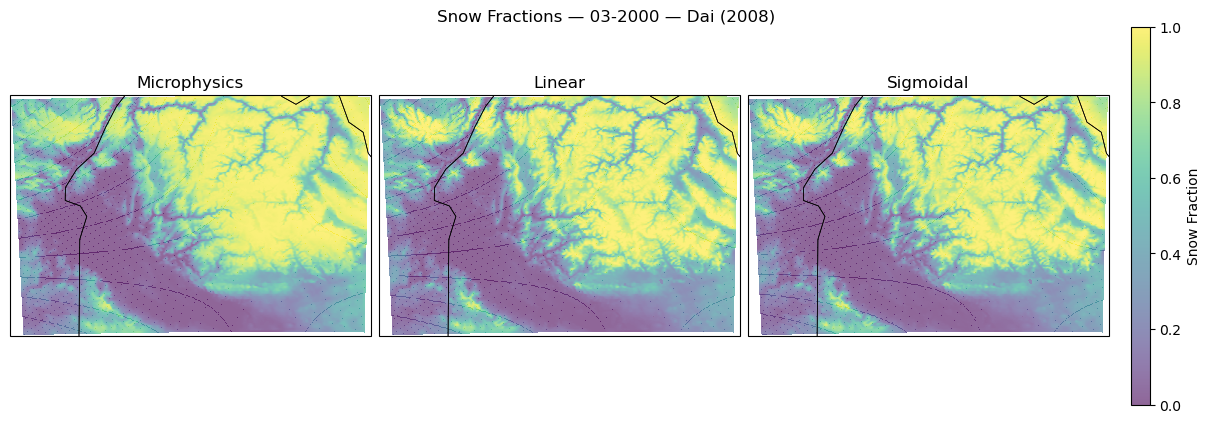

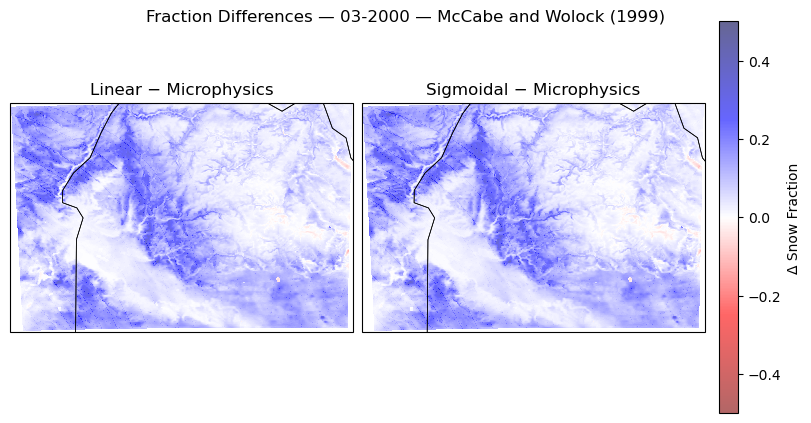

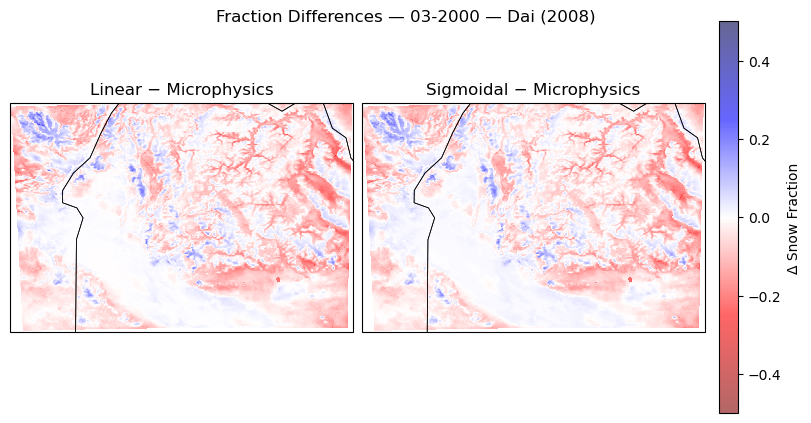

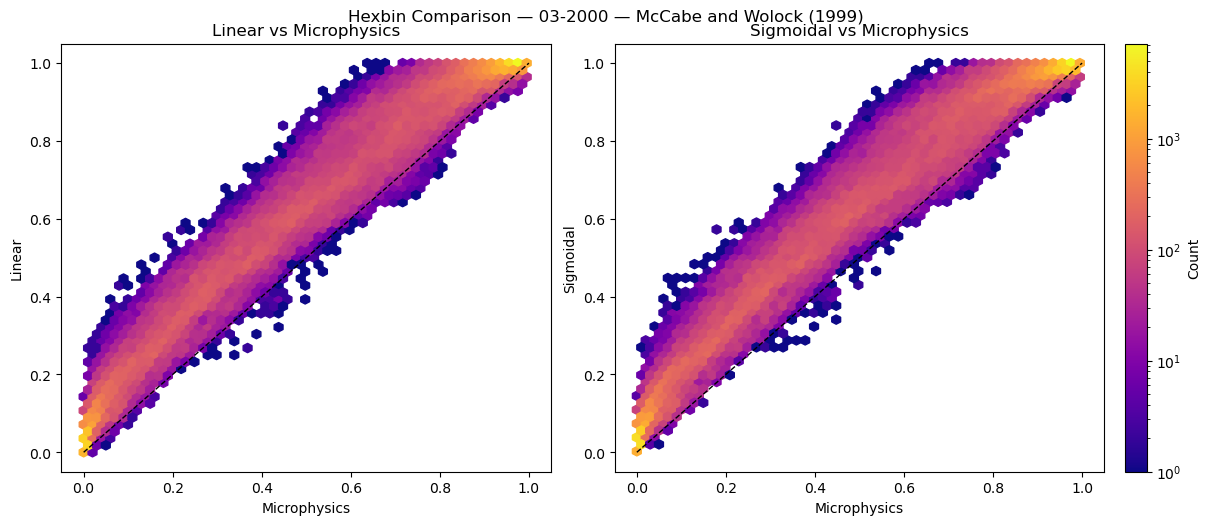

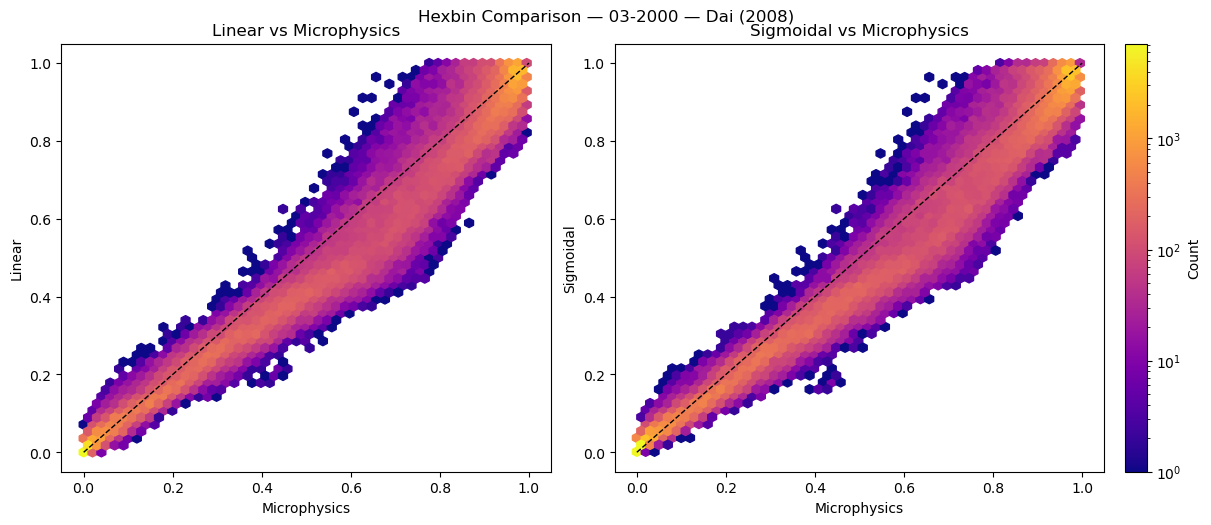

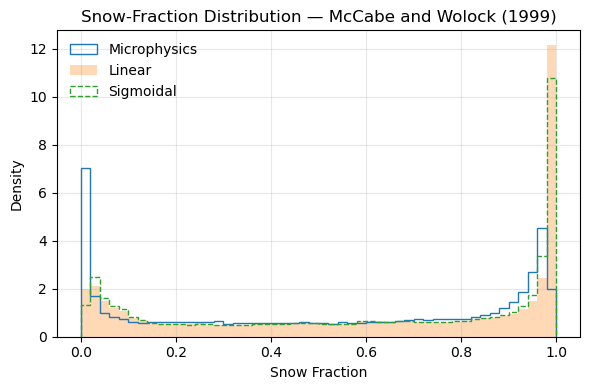

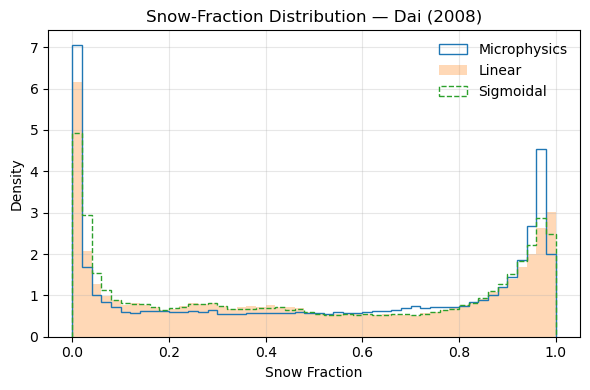

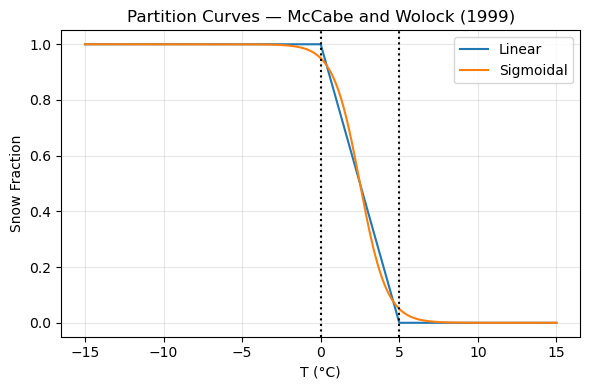

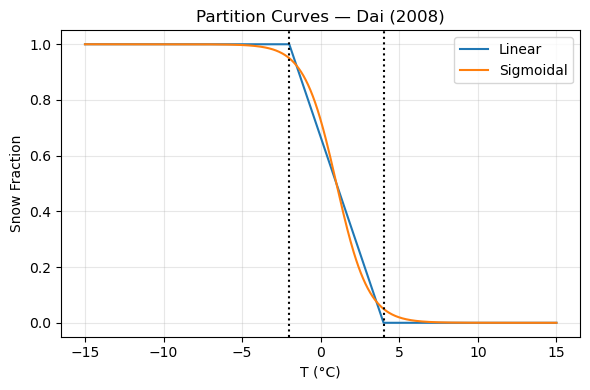

Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Precip in 0.0–5.0 °C band: 32.1%


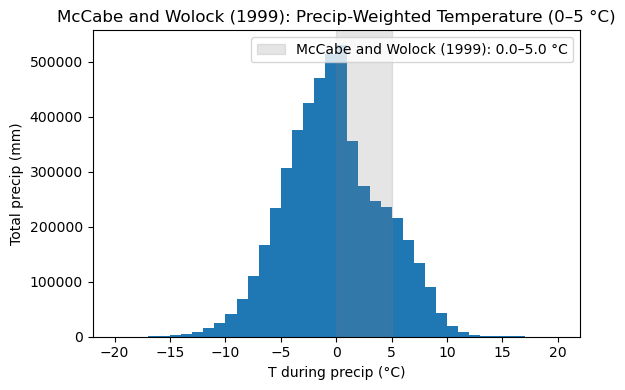

Loaded T2_2000-03.nc (cached)
Loaded I_RAINNC_2000-03.nc (cached)
Loaded RAINNC_2000-03.nc (cached)
Precip in -2.0–4.0 °C band: 46.8%


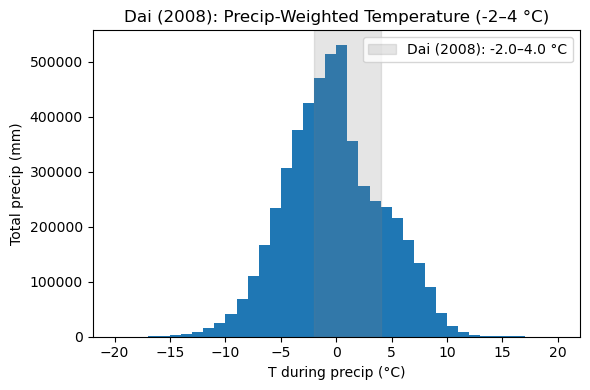

In [5]:
# -----------------------------------------------------------------------------  
# iterative_03_2000_driver.py — Driver / notebook cell  
# -----------------------------------------------------------------------------  
# * Load March 2000 WRF fields  
# * Compute snow fraction via microphysics, linear, and sigmoidal schemes  
# * Iterate over multiple temperature-threshold definitions  
# * Plot snow totals, snow fractions, diff maps, hexbins, histograms, partition curves,  
#   and transition-band analysis in grouped order  
# -----------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from importlib import reload

import plot_utils; reload(plot_utils)
from plot_utils import (
    load_wrf_var,
    compute_microphysics_snow_frac,
    compute_linear_snow_frac,
    compute_sigmoidal_snow_frac,
    cartomap,
    snow_frac_sigmoid
)

# ==========================
# CONFIG
# ==========================
D02_DIR = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"
YEAR, MONTH = "2000", "03"
EPSILON = 1e-6

# Temperature-threshold definitions
THRESHOLD_SOURCES = [
    {"name": "McCabe and Wolock (1999)", "T_snow":  0.0, "T_rain": 5.0},
    {"name": "Dai (2008)",              "T_snow": -2.0, "T_rain": 4.0},
]

# Partitioning schemes: (label, function)
SCHEME_FUNCS = [
    ("Microphysics", lambda: compute_microphysics_snow_frac(
        D02_DIR, YEAR, MONTH,
        min_precip_month=MIN_PRECIP_MONTH,
        epsilon=EPSILON
    )),
    ("Linear",       lambda T_snow, T_rain: compute_linear_snow_frac(
        D02_DIR, YEAR, MONTH,
        min_precip_hr=MIN_PRECIP_HR,
        TSNOW_THRESHOLD=T_snow,
        TRAIN_THRESHOLD=T_rain,
        epsilon=EPSILON,
        min_precip_month=MIN_PRECIP_MONTH
    )),
    ("Sigmoidal",    lambda T_snow, T_rain: compute_sigmoidal_snow_frac(
        D02_DIR, YEAR, MONTH,
        min_precip_hr=MIN_PRECIP_HR,
        T_snow=T_snow,
        T_rain=T_rain,
        F_snow=F_SNOW_TARGET,
        F_rain=F_RAIN_TARGET,
        epsilon=EPSILON,
        min_precip_month=MIN_PRECIP_MONTH
    )),
]

MIN_PRECIP_MONTH = 1.0   # mm for monthly mask
MIN_PRECIP_HR    = 0.1   # mm/hr for hourly filter
F_SNOW_TARGET    = 0.95
F_RAIN_TARGET    = 0.05

CMAP_MAP, CMAP_FRAC, CMAP_DIFF, CMAP_HEX = "Blues", "viridis", "seismic_r", "plasma"
FRAC_MIN, FRAC_MAX = 0.0, 1.0
DIFF_MIN, DIFF_MAX = -0.5, 0.5
SNOW_MIN          = 0.0
HEX_GRIDSIZE, HEX_TRIM_PCT = 50, 99.0

# ==========================
# LOAD GRID & MICROPHYSICS
# ==========================
print("Loading grid & computing microphysics snow fraction…")
t2_ds = load_wrf_var("T2", D02_DIR, YEAR, MONTH)
lons, lats = t2_ds["XLONG"][0].values, t2_ds["XLAT"][0].values

# call the first scheme (microphysics) immediately
_, snow_micro, _, frac_micro = SCHEME_FUNCS[0][1]()
fm_snow = np.ma.masked_invalid(snow_micro.values)
fm_frac = np.ma.masked_invalid(frac_micro.values)

# ==========================
# PRE-COMPUTE PPM SCHEMES
# ==========================
# we'll build dicts: scheme_name -> (snow, frac)
snow_partitions = {"Microphysics": fm_snow}
frac_partitions = {"Microphysics": fm_frac}

for entry in THRESHOLD_SOURCES:
    name, T_snow, T_rain = entry["name"], entry["T_snow"], entry["T_rain"]
    print(f"Computing PPM for '{name}'…")
    # linear
    _, snow_lin, _, frac_lin = SCHEME_FUNCS[1][1](T_snow, T_rain)
    snow_partitions[f"Linear — {name}"] = np.ma.masked_invalid(snow_lin.values)
    frac_partitions[f"Linear — {name}"] = np.ma.masked_invalid(frac_lin.values)
    # sigmoidal
    _, snow_sig, _, frac_sig = SCHEME_FUNCS[2][1](T_snow, T_rain)
    snow_partitions[f"Sigmoidal — {name}"] = np.ma.masked_invalid(snow_sig.values)
    frac_partitions[f"Sigmoidal — {name}"] = np.ma.masked_invalid(frac_sig.values)

# ==========================
# PLOTTING ROUTINES
# ==========================
def plot_panels(panel_dict, cmap, vmin, vmax, unit_label, figure_title):
    """
    panel_dict: {label: 2D array, ...}
    plots 1×N panels side by side with a single colorbar
    """
    labels = list(panel_dict.keys())
    arrays = list(panel_dict.values())
    N = len(arrays)

    fig, axes = plt.subplots(
        1, N, figsize=(4*N, 4),
        subplot_kw={'projection': ccrs.PlateCarree()},
        constrained_layout=True
    )
    if N == 1:
        axes = [axes]

    # draw each
    for ax, lab, arr in zip(axes, labels, arrays):
        m, _ = cartomap(
            ax, lons, lats, arr,
            title=lab,
            cmap=cmap, vmin=vmin, vmax=vmax,
            add_colorbar=False
        )

    cbar = fig.colorbar(
        m, ax=axes,
        orientation='vertical', fraction=0.03, pad=0.02
    )
    cbar.set_label(unit_label)
    fig.suptitle(figure_title, y=1.02)
    plt.show()


# 1) SNOW TOTALS
for entry in THRESHOLD_SOURCES:
    name = entry["name"]
    # pick out the micro, the linear & sigmoidal for this source
    panel = {
        "Microphysics": fm_snow,
        f"Linear": snow_partitions[f"Linear — {name}"],
        f"Sigmoidal": snow_partitions[f"Sigmoidal — {name}"],
    }
    SNOW_MAX = np.nanpercentile(np.concatenate([arr.ravel() for arr in panel.values()]), 99.0)
    plot_panels(
        panel,
        cmap=CMAP_MAP, vmin=SNOW_MIN, vmax=SNOW_MAX,
        unit_label="Snow Total (mm)",
        figure_title=f"Snow Totals — {MONTH}-{YEAR} — {name}"
    )

# 2) SNOW FRACTIONS
for entry in THRESHOLD_SOURCES:
    name = entry["name"]
    panel = {
        "Microphysics": fm_frac,
        f"Linear": frac_partitions[f"Linear — {name}"],
        f"Sigmoidal": frac_partitions[f"Sigmoidal — {name}"],
    }
    plot_panels(
        panel,
        cmap=CMAP_FRAC, vmin=FRAC_MIN, vmax=FRAC_MAX,
        unit_label="Snow Fraction",
        figure_title=f"Snow Fractions — {MONTH}-{YEAR} — {name}"
    )

# 3) FRACTION DIFFERENCE MAPS
for entry in THRESHOLD_SOURCES:
    name = entry["name"]
    diffs = {
        f"Linear − Microphysics": frac_partitions[f"Linear — {name}"] - fm_frac,
        f"Sigmoidal − Microphysics": frac_partitions[f"Sigmoidal — {name}"] - fm_frac,
    }
    plot_panels(
        diffs,
        cmap=CMAP_DIFF, vmin=DIFF_MIN, vmax=DIFF_MAX,
        unit_label="Δ Snow Fraction",
        figure_title=f"Fraction Differences — {MONTH}-{YEAR} — {name}"
    )

# 4) HEXBIN COMPARISONS
for entry in THRESHOLD_SOURCES:
    name = entry["name"]
    fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)
    for ax, scheme_name in zip(axes, ["Linear", "Sigmoidal"]):
        arr = frac_partitions[f"{scheme_name} — {name}"]
        hb = ax.hexbin(
            fm_frac.compressed(), arr.compressed(),
            gridsize=HEX_GRIDSIZE, cmap=CMAP_HEX,
            bins='log', mincnt=1
        )
        ax.plot([0,1],[0,1],'k--', lw=1)
        ax.set_title(f"{scheme_name} vs Microphysics")
        ax.set_xlabel("Microphysics")
        ax.set_ylabel(scheme_name)
    cbar = fig.colorbar(hb, ax=axes, orientation='vertical', fraction=0.03, pad=0.02)
    cbar.set_label("Count")
    fig.suptitle(f"Hexbin Comparison — {MONTH}-{YEAR} — {name}", y=1.02)
    plt.show()

# 5) SNOW-FRACTION HISTOGRAMS
for entry in THRESHOLD_SOURCES:
    name = entry["name"]
    fig, ax = plt.subplots(figsize=(6,4))
    bins = np.linspace(0,1,51)
    ax.hist(fm_frac.compressed(), bins=bins, density=True, histtype='step', label='Microphysics')
    ax.hist(frac_partitions[f"Linear — {name}"].compressed(), bins=bins, density=True,
            histtype='stepfilled', alpha=0.3, label='Linear')
    ax.hist(frac_partitions[f"Sigmoidal — {name}"].compressed(), bins=bins, density=True,
            histtype='step', linestyle='--', label='Sigmoidal')
    ax.set_xlabel("Snow Fraction"); ax.set_ylabel("Density")
    ax.set_title(f"Snow-Fraction Distribution — {name}")
    ax.legend(frameon=False); ax.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

# 6) PARAMETERIZATION CURVES
for entry in THRESHOLD_SOURCES:
    name, T_snow, T_rain = entry["name"], entry["T_snow"], entry["T_rain"]
    Tc = np.linspace(-15,15,601)
    flin = np.clip((T_rain - Tc)/(T_rain - T_snow), 0, 1)
    fsig = snow_frac_sigmoid(Tc, T_snow=T_snow, T_rain=T_rain,
                             F_snow=F_SNOW_TARGET, F_rain=F_RAIN_TARGET)
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(Tc,flin, label='Linear'); ax.plot(Tc,fsig, label='Sigmoidal')
    ax.axvline(T_snow, ls=':', color='k'); ax.axvline(T_rain, ls=':', color='k')
    ax.set_xlabel("T (°C)"); ax.set_ylabel("Snow Fraction")
    ax.set_title(f"Partition Curves — {name}")
    ax.legend(); ax.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

# 7) TRANSITION-BAND ANALYSIS
for entry in THRESHOLD_SOURCES:
    name, T_snow, T_rain = entry["name"], entry["T_snow"], entry["T_rain"]
    ds_t2   = load_wrf_var("T2",      D02_DIR, YEAR, MONTH)
    ds_cnt  = load_wrf_var("I_RAINNC",D02_DIR, YEAR, MONTH)
    ds_rain = load_wrf_var("RAINNC",  D02_DIR, YEAR, MONTH)
    precip_hr = plot_utils._hourly_precip(ds_cnt, ds_rain, MIN_PRECIP_HR)
    temps = (ds_t2["T2"] - 273.15).where(precip_hr>0).values.ravel()
    wts   = precip_hr.where(precip_hr>0).values.ravel()
    mask  = np.isfinite(temps)&np.isfinite(wts)
    temps, wts = temps[mask], wts[mask]
    band = (temps>=T_snow)&(temps<=T_rain)
    pct  = 100*wts[band].sum()/wts.sum()
    print(f"Precip in {T_snow}–{T_rain} °C band: {pct:.1f}%")
    fig, ax = plt.subplots(figsize=(6,4))
    bins = np.arange(-20,21,1)
    hist, edges = np.histogram(temps, bins=bins, weights=wts)
    centers = 0.5*(edges[:-1]+edges[1:])
    ax.bar(centers, hist, width=1, align='center')
    ax.axvspan(T_snow, T_rain, color='grey', alpha=0.2,
               label=f"{name}: {T_snow}–{T_rain} °C")
    ax.legend(loc="upper right")
    ax.set_xlabel("T during precip (°C)")
    ax.set_ylabel("Total precip (mm)")
    ax.set_title(f"{name}: Precip-Weighted Temperature ({T_snow:.0f}–{T_rain:.0f} °C)")
    plt.tight_layout(); plt.show()
